In [ ]:
# Import necessary libraries
import os                              # For file and directory operations
import cv2                             # For image loading and preprocessing
import numpy as np                     # For numerical operations
import matplotlib.pyplot as plt        # For plotting images and graphs

# Keras modules for image preprocessing, model building, and training
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For data loading and augmentation
from tensorflow.keras.models import Model                            # For defining custom models
from tensorflow.keras.layers import Dense, Flatten, Dropout          # Common layers used in CNNs

# Pre-trained VGG19 model from Keras applications
from tensorflow.keras.applications.vgg19 import VGG19                # For transfer learning

# Optimizer and training callbacks
from tensorflow.keras.optimizers import Adam                         # Adaptive optimizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau  # For stopping early & reducing LR

In [ ]:
# checking if a GPU device is available
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Check the number of images in each class (NORMAL and PNEUMONIA) across train, test, and val folders
lst = ['train', 'test', 'val']

for item in lst:
    print(f"images in {item}/NORMAL -> ", len(os.listdir(f"/content/drive/MyDrive/chest_xray/{item}/NORMAL")))
    print(f"images in {item}/PNEUMONIA -> ", len(os.listdir(f"/content/drive/MyDrive/chest_xray/{item}/PNEUMONIA")), end="\n\n")

images in train/NORMAL ->  1341
images in train/PNEUMONIA ->  3875

images in test/NORMAL ->  234
images in test/PNEUMONIA ->  390

images in val/NORMAL ->  8
images in val/PNEUMONIA ->  8



In [ ]:
# Get list of image filenames from the PNEUMONIA training folder
pneumonia_dir = "/content/drive/MyDrive/chest_xray/train/PNEUMONIA"
pneumonia_images = os.listdir(pneumonia_dir)

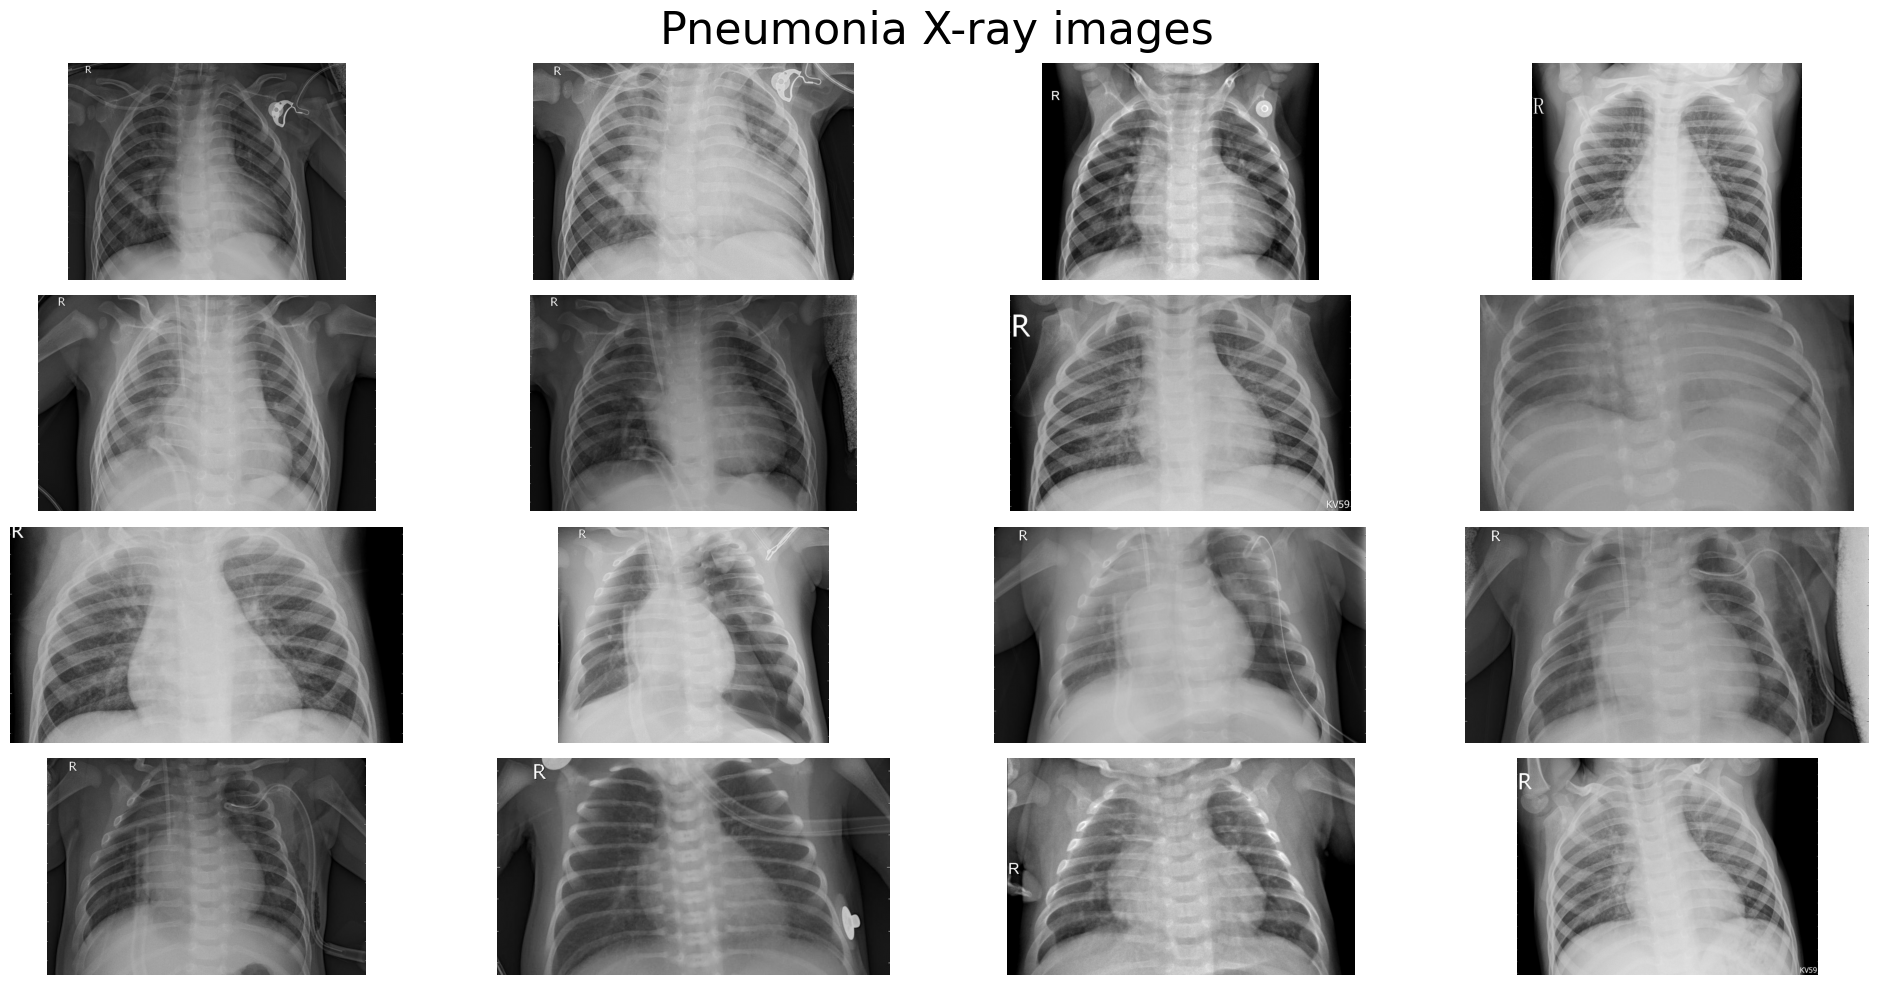

In [ ]:
# Display 16 sample pneumonia X-ray images in a 4x4 grid
plt.figure(figsize=(20, 10))
plt.suptitle("Pneumonia X-ray images", fontsize=32)

for i in range(16):
    plt.subplot(4, 4, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia_images[i]))  # Load image
    plt.imshow(img, cmap='gray')  # Show in grayscale
    plt.axis("off")  # Hide axes

plt.tight_layout()  # Adjust layout to prevent overlap

In [ ]:
# Get list of image filenames from the NORMAL training folder
normal_dir = "/content/drive/MyDrive/chest_xray/train/NORMAL"
normal_images = os.listdir(normal_dir)

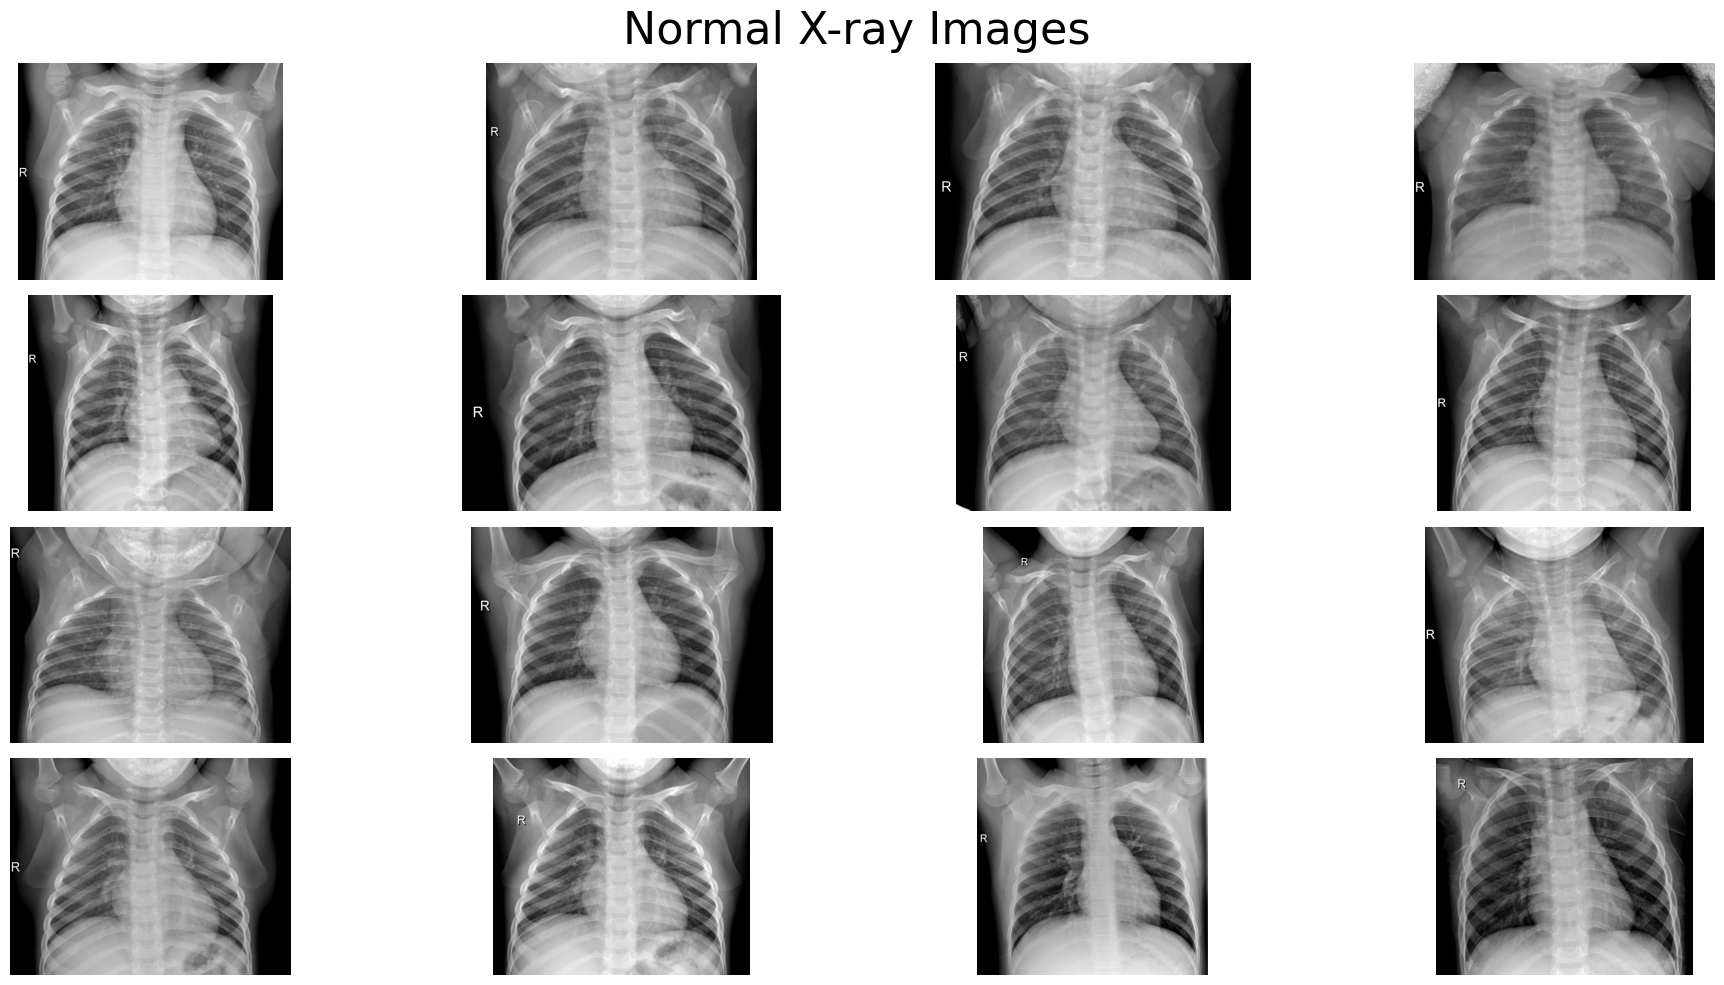

In [ ]:
# Display 16 sample normal X-ray images in a 4x4 grid
plt.figure(figsize=(20, 10))
plt.suptitle("Normal X-ray Images", fontsize=32)

for i in range(16):
    plt.subplot(4, 4, i + 1)
    img = plt.imread(os.path.join(normal_dir, normal_images[i]))  # Load image
    plt.imshow(img, cmap='gray')  # Show in grayscale
    plt.axis("off")  # Hide axes

plt.tight_layout()  # Adjust layout to avoid overlap

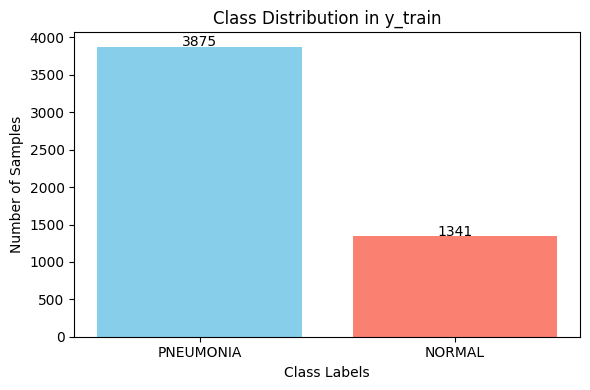

In [ ]:
# Get unique labels and their counts from training labels
uniq_labels, label_counts = np.unique(y_train, return_counts=True)

# Create bar plot for class distribution
plt.figure(figsize=(6, 4))
plt.bar(uniq_labels, label_counts, color=['skyblue', 'salmon'])

# Add axis labels and title
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in y_train')
plt.xticks(uniq_labels, ['PNEUMONIA', 'NORMAL'])  # Set custom x-axis tick labels

# Show count on top of each bar
for i, count in enumerate(label_counts):
    plt.text(uniq_labels[i], count + 5, str(count), ha='center')

plt.tight_layout()
plt.show()

In [ ]:
# Image data generator with augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1. / 255,             # Normalize pixel values
    horizontal_flip=True,         # Random horizontal flip
    vertical_flip=True,           # Random vertical flip
    rotation_range=40,            # Random rotation (up to 40 degrees)
    shear_range=0.2,              # Shear transformation
    width_shift_range=0.4,        # Horizontal shift
    height_shift_range=0.4,       # Vertical shift
    fill_mode="nearest"           # Fill in newly created pixels
)

# Data generators for validation and test data (only rescaling)
valid_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [ ]:
# Create data generator for training set with augmentation
train_generator = train_datagen.flow_from_directory(
    directory="/content/drive/MyDrive/chest_xray/train",     # Path to training data
    batch_size=32,                    # Number of images per batch
    target_size=(128, 128),           # Resize images to 128x128
    class_mode='categorical',         # One-hot encode labels
    shuffle=True,                     # Shuffle data each epoch
    seed=42,                          # Random seed for reproducibility
    color_mode='rgb'                  # Read images in RGB (3 channels)
)

# Create data generator for validation set (no augmentation)
valid_generator = valid_datagen.flow_from_directory(
    directory="/content/drive/MyDrive/chest_xray/val",
    batch_size=32,
    target_size=(128, 128),
    class_mode='categorical',
    shuffle=True,
    seed=42,
    color_mode='rgb'
)

# Create data generator for test set (no augmentation)
test_generator = test_datagen.flow_from_directory(
    directory="/content/drive/MyDrive/chest_xray/test",
    batch_size=32,
    target_size=(128, 128),
    class_mode='categorical',
    shuffle=True,
    seed=42,
    color_mode='rgb'
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
# Get the mapping of class names to class indices (e.g., {'NORMAL': 0, 'PNEUMONIA': 1})
class_labels = train_generator.class_indices
class_labels

{'NORMAL': 0, 'PNEUMONIA': 1}

In [ ]:
# Reverse the class_labels dictionary to map indices back to class names
class_name = {value: key for (key, value) in class_labels.items()}
class_name

{0: 'NORMAL', 1: 'PNEUMONIA'}

## VGG19 Fine-Tuning

In [ ]:
# Load the VGG19 model without the top classification layer, using pretrained ImageNet weights
base_model = VGG19(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze all layers in the base VGG19 model
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze only block5_conv1 to block5_conv4
for layer in base_model.layers:
    if layer.name in ['block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_conv4']:
        layer.trainable = True

# Add custom classification layers on top
x = base_model.output
flat = Flatten()(x)  # Flatten the output of the convolutional base

dense_layer_1 = Dense(4096, activation='relu')(flat)  # Fully connected layer
dropout_1 = Dropout(0.2)(dense_layer_1)               # Dropout to prevent overfitting

dense_layer_2 = Dense(2048, activation='relu')(dropout_1)  # Another dense layer
dropout_2 = Dropout(0.2)(dense_layer_2)                    # Dropout again

dense_layer_3 = Dense(1024, activation='relu')(dropout_2)  # Third dense layer

output = Dense(2, activation='softmax')(dense_layer_3)     # Output layer for 2 classes (PNEUMONIA, NORMAL)

# Create final model
model = Model(base_model.inputs, output)
model.summary()  # Display model architecture

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    33,558,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             

 Total params: 64,073,794 (244.42 MB)

 Trainable params: 53,488,642 (204.04 MB)

 Non-trainable params: 10,585,152 (40.38 MB)

In [ ]:
# EarlyStopping to stop training if validation loss doesn't improve
es = EarlyStopping(
    monitor="val_loss",
    verbose=1,
    mode="min",
    patience=4  # Stop if no improvement in val_loss for 4 epochs
)

# ReduceLROnPlateau to reduce learning rate when validation accuracy plateaus
lrr = ReduceLROnPlateau(
    monitor="val_accuracy",
    patience=3,       # Wait 3 epochs before reducing LR
    verbose=1,
    factor=0.5,       # Reduce LR by half
    min_lr=0.0001     # Minimum learning rate
)

# Adam optimizer with custom learning rate and decay
adam = Adam(learning_rate=0.0001, decay=1e-6)

# Compile the model with categorical crossentropy loss and accuracy metric
model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
# Train the model using the training data generator
history = model.fit(
    x=train_generator,                # Training data
    epochs=40,                        # Number of epochs
    callbacks=[es, lrr],              # Early stopping & LR scheduler
    validation_data=valid_generator   # Validation data
)

# Save the trained model to disk
model.save("VGG19 Fine-Tuned model.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


163/163 ━━━━━━━━━━━━━━━━━━━━ 120s 651ms/step - accuracy: 0.8104 - loss: 0.4192 - val_accuracy: 0.6875 - val_loss: 1.2296 - learning_rate: 1.0000e-04
Epoch 2/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 126s 620ms/step - accuracy: 0.9196 - loss: 0.2041 - val_accuracy: 0.8750 - val_loss: 0.2226 - learning_rate: 1.0000e-04
Epoch 3/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 614ms/step - accuracy: 0.9362 - loss: 0.1638 - val_accuracy: 0.8125 - val_loss: 0.2711 - learning_rate: 1.0000e-04
Epoch 4/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 616ms/step - accuracy: 0.9365 - loss: 0.1608 - val_accuracy: 0.8125 - val_loss: 1.0364 - learning_rate: 1.0000e-04
Epoch 5/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 617ms/step - accuracy: 0.9465 - loss: 0.1435 - val_accuracy: 0.9375 - val_loss: 0.2116 - learning_rate: 1.0000e-04
Epoch 6/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 621ms/step - accuracy: 0.9513 - loss: 0.1281 - val_accuracy: 0.9375 - val_loss: 0.1433 - learning_rate: 1.0000e-04
Epoch 7/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 616ms/

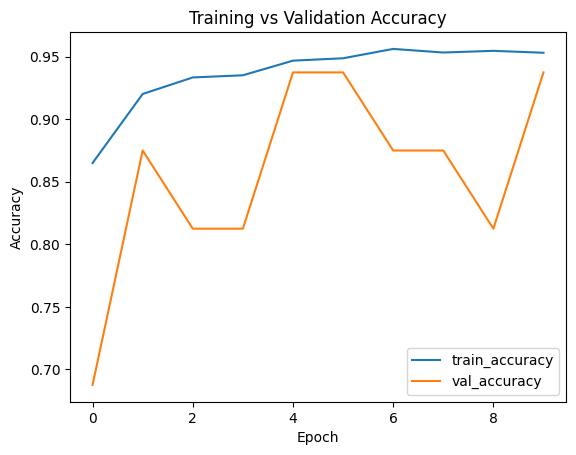

In [ ]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

In [ ]:
# Evaluate model performance on the training set
eval_on_train = model.evaluate(train_generator)

# Evaluate model performance on the validation set
eval_on_val = model.evaluate(valid_generator)

# Evaluate model performance on the test set
eval_on_test = model.evaluate(test_generator)

163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 610ms/step - accuracy: 0.9641 - loss: 0.1054
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.9375 - loss: 0.1966
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 366ms/step - accuracy: 0.9225 - loss: 0.2492
